- **This code computes the decomposed solution of a Closed-Loop DRTO problem.**
- Using tracking objective function
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC N.B.:strategy 2 not working
- The problem is posed as a scenario-based stochastic programming problem
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file
- We study the impact of the increase in the number of reactors in the crossover point

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames, Distributions, LaTeXStrings

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 2.4 # for tight constraints: 1.9 | for loose constraints: 5.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building affine CL-DRTO models

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\Preliminary calculations\\BioreactorModel", DataFrame; header=false);

CL-DRTO configuration

In [4]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1)# p = 8 *controller horizon  
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

DRTO model changes with the number of scenarios and parallel reactors

In [5]:
function DRTO_matrices(nReactors,nScenarios)
    # ATTENTION: Used for the monolithic solution. It generates an array of models
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the models based on a fixed index grid that is generated based on the number of scenarios
    
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1/nReactors], outer = [1, nReactors])
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

In [6]:
function DRTO_matrix(nReactors,nScenario,nScenTotal)
    # ATTENTION: Used for the decomposed solution. It generates a single model
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the model of interest based on the index "nScenario"
  
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenario - index the of scenario used in the stochastic optimization
    # nScenTotal - total number of scenario used in the stochastic optimization
    
    if nScenTotal == 1
        index_temp = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenTotal-1)) for ii in 1:nScenTotal]
        index_temp = indexScen[nScenario]
    end
  
    # building DRTO model
    A_drto = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
    B_drto = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1/nReactors], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

# Building MPC model

Controller configuration

In [7]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

Notes:
- Using nominal model(indexScen = 50)
- For the description of how the MPC matrices (with disturbance model) are built, check script: check *Different Strategies to solve constrained MPC within CLDRTO* --> Preliminary calculation

In [8]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1/nReactors], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

# Solving CL-DRTO Multiscenario Problem (monolithic)
 - Check details in script *Testing Monolithic CLDRTO* --> Preliminary calculations/Linear Bioreactor
 - For the description of the different solution strategies, check *Different Strategies to solve constrained MPC within CLDRTO* --> Preliminary calculation

In [9]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 10000#1000
bigM_u = 10000#100

# weight complementarity relaxation OF term
pi_bar = 10^2; # 10^2

In [10]:
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)

    # Define model
    if option == 3 || option == 1
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
     if option == 1
        @variable(model_ms, u_w_c[1:pD,1:m,1:nScen]) # inputs w/o clipping
    
        # input clipping 
        @variable(model_ms, mu_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, mu_ub[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_ub[1:pD,1:m,1:nScen] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################    
    if option == 1
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u_w_c[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])
        
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u_w_c[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u_w_c[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping
        @constraint(model_ms, ic_1[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] == u_w_c[kk,uu,ss] - mu_ub[kk,uu,ss] + mu_lb[kk,uu,ss])
        @constraint(model_ms, ic_2[kk = 1:mD,uu = 1:m,ss = 1:nScen], (uMax - u0) - u[kk,uu,ss] == eta_ub[kk,uu,ss])
        @constraint(model_ms, ic_3[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_ub[kk,uu,ss]*mu_ub[kk,uu,ss] ≤ 1e-6)
        @constraint(model_ms, ic_4[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] - (uMin - u0) == eta_lb[kk,uu,ss])
        @constraint(model_ms, ic_5[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_lb[kk,uu,ss]*mu_lb[kk,uu,ss] ≤ 1e-6)
        
    elseif option == 2
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
        # Expressions for OF
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
    end
      
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    #set_optimizer_attribute(model_ms, "CPX_PARAM_BARALG", 1)
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xDRTOArray,
                        'c' => yDRTOArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

# Decomposition of CLDRTO Problem

<div>
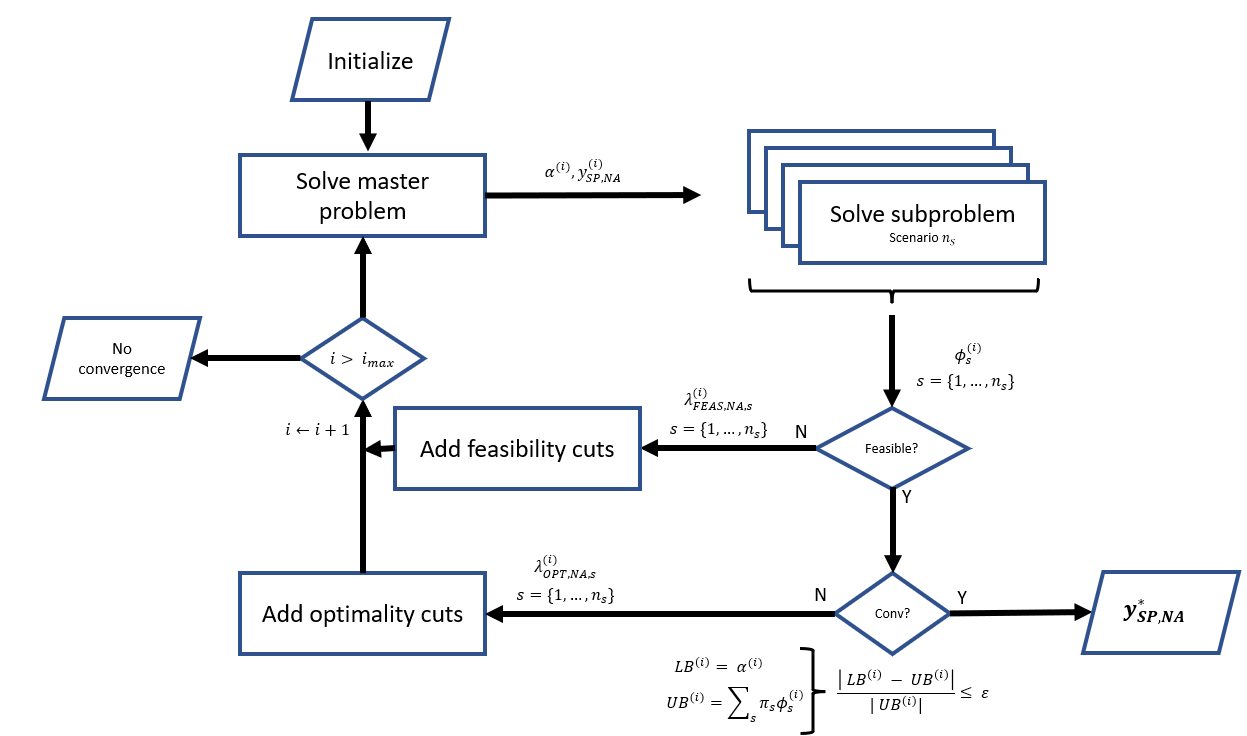
</div>

## Modeling Subproblem

In [11]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - setpoints fixed by the Master Problem --> nonanticipativity constraints
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC 
        # for now, code only works for option = 3

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    
    # recomputing the number of total scenarios based on scenario probability and the fact that the scenarios have the same probability
    nScenTotal = ceil(Int,1/pScen)    
    drto = DRTO_matrix(nReac,nScen,nScenTotal)
    
    # Define subproblem model  #== 3
    if option == 3 || option == 1 
        sub = Model(Ipopt.Optimizer)
        set_optimizer_attribute(sub, "max_cpu_time", 300.0) # 5 min
    else 
        sub = Model(CPLEX.Optimizer)
        set_optimizer_attribute(sub, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(sub) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])
    if option == 1
        @variable(sub, u_w_c[1:pD,1:m]) # inputs w/o clipping
    
        # input clipping 
        @variable(sub, mu_lb[1:pD,1:m] ≥ 0)
        @variable(sub, eta_lb[1:pD,1:m] ≥ 0)
        @variable(sub, mu_ub[1:pD,1:m] ≥ 0)
        @variable(sub, eta_ub[1:pD,1:m] ≥ 0)       
    end

    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
        
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_p[1:pD] ≥ 0)
    
    if option == 2 || option == 3
        @variable(sub, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(sub, Y_lb[1:mD,1:m], start = 0) # Relaxing binaries for big-M implementation
        @variable(sub, Y_ub[1:mD,1:m], start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:pD
            set_start_value(yDRTO[ii], solNom['y'][ii,1]) 
            set_start_value(yMPC[ii], solNom['c'][ii,1])
            #set_start_value(ysp[ii], solNom['s'][ii,1])

            for rr in 1:nReac # when nReac increases, the number of states change!
                for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                    set_start_value(xDRTO[ii,xx + (rr - 1)*2], solNom['x'][ii,xx,1])    
                    set_start_value(xMPC[ii,xx + (rr - 1)*2], solNom['m'][ii,xx,1])           
                end # end xx
            end # number 
                
            for uu in 1:m
                set_start_value(u[ii,uu], solNom['u'][ii,uu,1])
            end # end of uu
        end # eend of ii
    end # end of if

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== drto['A']*xInit + drto['B']*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== drto['A']*xDRTO[kk,:] + drto['B']*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == dot(drto['C'],xDRTO[kk,:]))

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # P soft constraints
    @constraint(sub, soft_P[kk=1:pD], yDRTO[kk] - delta_p[kk] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################
    ################
    # MPC solution #
    ################ 
    if option == 1
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u_w_c[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Unconstrained MPC solution  
        @constraint(sub, MPC_sol_1, mpc['H']*u_w_c[1,:] + cfT_1' .== 0)
        @constraint(sub, MPC_sol[kk=2:mD],mpc['H']*u_w_c[kk,:] + cfT[kk]' .== 0)

        # input clipping
        @constraint(sub, ic_1[kk = 1:mD,uu = 1:m], u[kk,uu] == u_w_c[kk,uu] - mu_ub[kk,uu] + mu_lb[kk,uu])
        @constraint(sub, ic_2[kk = 1:mD,uu = 1:m], (uMax - u0) - u[kk,uu] == eta_ub[kk,uu])
        @constraint(sub, ic_3[kk = 1:mD,uu = 1:m], eta_ub[kk,uu]*mu_ub[kk,uu] ≤ 1e-6)
        @constraint(sub, ic_4[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMin - u0) == eta_lb[kk,uu])
        @constraint(sub, ic_5[kk = 1:mD,uu = 1:m], eta_lb[kk,uu]*mu_lb[kk,uu] ≤ 1e-6)
    
    elseif option == 2
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] ≤ bigM_mu*Y_ub[kk,uu])
        @constraint(sub, bigM_2[kk=1:mD,uu=1:m], mu_g[kk,uu + m] ≤ bigM_mu*Y_lb[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu]))
        @constraint(sub, bigM_4[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≥ -bigM_u*(1 - Y_lb[kk,uu]))
        
        @constraint(sub, compSlack[kk=1:mD,uu=1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    elseif option == 3
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility       
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
        
        # expression to be used in OF        
        @expression(sub, g_u_u[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0))
        @expression(sub, g_u_l[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu])
        
    end

    #############################
    # Set up objective function #
    #############################
     if option == 1 || option == 2
        @objective(sub, Min, 
            pScen*sum((yDRTO[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
        )
    else
        @objective(sub, Min, 
            pScen*sum((yDRTO[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
                    - pScen*pi_bar*sum(
                                    sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                                    sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                                for kk = 1:mD)
        )
    end
    
    # @show sub
    #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)
    
    optimize!(sub)
    
    # solution time
    timeSol = solve_time(sub)
    
    status = termination_status(sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)

        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
        # if binaries are used for solving const. MPC
        if option == 2
            muArray = value.(mu_g)
                   
            uubBinArray = value.(Y_ub)
            ulbBinArray = value.(Y_lb)
            
            merge!(outputDict,Dict('μ'=> muArray))
            merge!(outputDict,Dict('o' => ulbBinArray))
            merge!(outputDict,Dict('p' => uubBinArray))
            
        end
        
        # if MPCC is used for solving const. MPC
        if option == 3
            muArray = value.(mu_g)
            
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        

        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        # ! soft bounds on y
        #delete_lower_bound.(yDRTO[1:pD])
        
        if option != 1
            # ! soft bounds on mu
            delete_lower_bound.(mu_g[1:mD,1:m])
            
            # ! soft bounds on u
            for kk in 1:mD
                for uu in 1:m
                    delete(sub, MPC_c_upper[kk,uu])
                    delete(sub, MPC_c_lower[kk,uu])
                end
            end
        end
        
        ####################
        # Set up variables #
        ####################         
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        
        #@variable(sub, delta_y_l[1:pD] ≥ 0.0)
        
        if option == 2 || option == 3
            @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)
            
            # slacks
            @variable(sub, delta_u_u[1:mD,1:m] ≥ 0.0)
            @variable(sub, delta_u_l[1:mD,1:m] ≥ 0.0)

        end
        
        ###########################
        # Always-feasible problem #
        ###########################        
        @constraint(sub, soft_ysp_upper[kk=1:pD], ysp[kk] - (yspMax - y0) ≤ delta_ysp_u[kk])
        @constraint(sub, soft_ysp_lower[kk=1:pD], (yspMin - y0) - ysp[kk] ≤ delta_ysp_l[kk])
        
        #@constraint(sub, soft_y_lower[kk=1:pD], (0 - y0) - yDRTO[kk] ≤ delta_y_l[kk])

        # adding a constraint to guarantee that mu is always feasible        
        if option == 2 || option == 3
            @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], -mu_g[kk,uu] ≤ delta_mu[kk,uu])
            
            # adding a constraint to guarantee feasibility
            @constraint(sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
            @constraint(sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        end
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        if option == 2 || option == 3
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_mu[kk,uu] + delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        else
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD))
        end
        
        #@show sub
        #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # solution time (adding time to solve the always feasible subproblem)
        timeSol = timeSol + solve_time(sub)
        
        # checking status of the solution
        status_sub = termination_status(sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
    
        # objective function of the feasibility problem
        o = objective_value(sub)
        
        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
         if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    end
end;

Modeling Bender's Decomposition

In [12]:
# max number of iteration
benIterMax = 50

# optimality gap (relative) tolerance
optGap = 1e-3; # UNC/BIN: 0.001 | MPCC: 0.5

In [13]:
## Modeling Benders Decompostion
function BENS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(CPLEX.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down = 0.0;
    
    ####################
    # Set up variables #
    ####################
    @variable(master,  (yspMin - y0) <= ysp[1:nDRTO] <=  (yspMax - y0))     
    @variable(master, α ≥ alpha_down)
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:nDRTO
            set_start_value(ysp[ii], solNom['s'][ii,1])
        end 
    end 
 
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
           
        #############################
        # Set up objective function #
        #############################
        if flagO == 1 
            # last cut was an optimality cut
            # standard OF
            @objective(master, Min, α)
        else
            # last cut was a feasibility cut
            # "nudge" next solution towards nominal solution 
            @objective(master, Min, α + 0*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:nDRTO))
        end
        
            # solve master problem (with Benders' cut)
            optimize!(master)

            # solution time
            timeSolMaster = solve_time(master)
            # Master problem solution: lower bound of the original problem
            lb = objective_value(master)
            #display(lb)

            # extracting solution for the non-anticipativity constraints
            ysp_nonⁱ = value.(ysp)
            #display(ysp_nonⁱ)

        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,nScen)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,nScen)
        # solution time
        solTime_temp = Vector{Float64}(undef,nScen)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,nDRTO,nScen) 
        
        for ss in 1:nScen
            dicTemp = subp(xInit,uInit,ysp_nonⁱ,nReac,ss,pScen,solNom,option)
           
            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:nDRTO
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == nScen 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            display("DB: opt gap = $(gap)")

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")

            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii >= benIterMax
            global yspSol_dec = [NaN for kk=1:nDRTO]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations
    
    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => time_dec,
                         'ϕ' => objFun_dec,
                         'm' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec)
                        
        
        return outputFun
        
    else
        # recomputing values
        uArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['u']' for ss in 1:nScen]
        yArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['y']' for ss in 1:nScen] 
        yspArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['s']' for ss in 1:nScen]

        #calling values of the solved problem
        return Dict('ϕ' => objFun_dec, 
                    'd' => yspSol_dec, 
                    't' => time_dec,
                    'm' => time_max_dec, 
                    'i' => iter_dec,
                    'g' => optGap_dec,
                    'u' => uArray, 
                    'y' => yArray, 
                    's' => yspArray)
    end     
end;

# Checking the performance of the methods in terms of time vs. nScen

In [14]:
# testing the number of scenarios
nScenMax = 50 # 3 | 30 | 50 

# number of reactors in parallel
nReactors = 2 # 5 | 10 | 20 | 30


#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# computed objective function
solObjTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_s = Vector{Float64}(undef,nScenMax) 
# number of iterations
iterTraj_s = Vector{Float64}(undef,nScenMax) 
# optimality gap
optGapTraj_s = Vector{Float64}(undef,nScenMax) 

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReactors,1])
uInit_0 = 1.0 - u0;

#option = 1 --> Unconstrained MPC
#option = 2 --> Constrained MPC with binaries --> DOES NOT WORK YET!
#option = 3 --> Constrained MPC with MPCC
opti = 3
    
# Computing nominal solution #
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,opti); 

for ss = 1:nScenMax
    display("evaluating $(ss) scenarios| option $(opti)")

    #number os scenarios
    nScen = ss
    #equiprobable scenarios
    pScen = 1.0/nScen
    # Number of states
    nx = 2*nReactors
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)

    # solving decomposed problem
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)
    
    # for plotting
    display("time M $(sol_m_Dict['t']) | time D $(sol_d_Dict['t'])")
    solTimeTraj_s[1,ss] = sol_m_Dict['t']
    solTimeTraj_s[2,ss] = sol_d_Dict['t']
    solObjTraj_s[1,ss] = sol_m_Dict['ϕ']
    solObjTraj_s[2,ss] = sol_d_Dict['ϕ']
    
    solTimeMaxTraj_s[ss] = sol_d_Dict['m']
    iterTraj_s[ss] = sol_d_Dict['i'] 
    optGapTraj_s[ss] = sol_d_Dict['g']
end



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"evaluating 1 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.950075186202999"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7359498807631178"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5374496513923062"

">>>>>> iteration 7:O"

"DB: opt gap = 0.528424757920487"

">>>>>> iteration 8:O"

"DB: opt gap = 0.46660395062339927"

">>>>>> iteration 9:O"

"DB: opt gap = 0.016689236082721087"

">>>>>> iteration 10:O"

"DB: opt gap = 0.016560901117821714"

">>>>>> iteration 11:O"

"DB: opt gap = 0.016463087614755074"

">>>>>> iteration 12:O"

"DB: opt gap = 0.01627868495901094"

">>>>>> iteration 13:O"

"DB: opt gap = 0.016233306177821292"

">>>>>> iteration 14:O"

"DB: opt gap = 0.015758892285271376"

">>>>>> iteration 15:O"

"DB: opt gap = 0.015646639086306393"

">>>>>> iteration 16:O"

"DB: opt gap = 0.015096111109505778"

">>>>>> iteration 17:O"

"DB: opt gap = 0.014994603585329669"

">>>>>> iteration 18:O"

"DB: opt gap = 5.340041852464904e-5"

"time M 0.11299991607666016 | time D 1.8529994487762451"

"evaluating 2 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6904738802625301"

">>>>>> iteration 8:O"

"DB: opt gap = 0.6071355449605944"

">>>>>> iteration 9:O"

"DB: opt gap = 0.6375261263837942"

">>>>>> iteration 10:O"

"DB: opt gap = 0.0787259362766003"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07550214174121608"

">>>>>> iteration 12:O"

"DB: opt gap = 0.0002784408306618679"

"time M 0.372999906539917 | time D 3.1649999618530273"

"evaluating 3 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7554323068576974"

">>>>>> iteration 8:O"

"DB: opt gap = 0.6925474638168679"

">>>>>> iteration 9:O"

"DB: opt gap = 0.08034572300960312"

">>>>>> iteration 10:O"

"DB: opt gap = 0.07975740502098738"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07871933819919692"

">>>>>> iteration 12:O"

"DB: opt gap = 0.0781569100943126"

">>>>>> iteration 13:O"

"DB: opt gap = 0.00010949380684728937"

"time M 0.39300012588500977 | time D 4.844999551773071"

"evaluating 4 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 0.034860969917564995"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03436491895971638"

">>>>>> iteration 12:O"

"DB: opt gap = 0.034047400343706596"

">>>>>> iteration 13:O"

"DB: opt gap = 0.034059666632044"

">>>>>> iteration 14:O"

"DB: opt gap = 0.03365662539237609"

">>>>>> iteration 15:O"

"DB: opt gap = 1.3246472941946238e-5"

"time M 0.30699992179870605 | time D 7.9260008335113525"

"evaluating 5 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 0.1195160802518321"

">>>>>> iteration 8:O"

"DB: opt gap = 0.1188875426595531"

">>>>>> iteration 9:O"

">>>>>> iteration 10:F"

"DB: opt gap = 0.11752907193444175"

">>>>>> iteration 11:O"

"DB: opt gap = 0.11634716905787199"

">>>>>> iteration 12:O"

"DB: opt gap = 0.09740880717559978"

">>>>>> iteration 13:O"

"DB: opt gap = 0.09418034781683582"

">>>>>> iteration 14:O"

"DB: opt gap = 0.09348333230127455"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0784850927235287"

">>>>>> iteration 16:O"

"DB: opt gap = 0.07786610078051745"

">>>>>> iteration 17:O"

"DB: opt gap = 0.002467587499375015"

">>>>>> iteration 18:O"

"DB: opt gap = 0.002461985888011317"

">>>>>> iteration 19:O"

"DB: opt gap = 0.0026224901344467084"

">>>>>> iteration 20:O"

"DB: opt gap = 2.3296413682062185e-6"

"time M 1.0829999446868896 | time D 13.272000789642334"

"evaluating 6 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 0.10643779039799595"

">>>>>> iteration 9:O"

"DB: opt gap = 0.10595443954079671"

">>>>>> iteration 10:O"

"DB: opt gap = 0.10467313242228442"

">>>>>> iteration 11:O"

"DB: opt gap = 0.10420871927050263"

">>>>>> iteration 12:O"

"DB: opt gap = 0.10350268819933033"

">>>>>> iteration 13:O"

"DB: opt gap = 0.10251726987879115"

">>>>>> iteration 14:O"

"DB: opt gap = 1.7089519213053382e-5"

"time M 2.246999979019165 | time D 9.232000827789307"

"evaluating 7 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 0.12329247054902935"

">>>>>> iteration 9:O"

"DB: opt gap = 0.12254029983325823"

">>>>>> iteration 10:O"

"DB: opt gap = 0.12114605525667765"

">>>>>> iteration 11:O"

"DB: opt gap = 0.11966265366302868"

">>>>>> iteration 12:O"

"DB: opt gap = 0.11779140046634556"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1164439084338918"

">>>>>> iteration 14:O"

"DB: opt gap = 0.11587613356105601"

">>>>>> iteration 15:O"

"DB: opt gap = 0.11484116359562631"

">>>>>> iteration 16:O"

"DB: opt gap = 0.11331112371074548"

">>>>>> iteration 17:O"

"DB: opt gap = 0.0001061008803521524"

"time M 2.6510000228881836 | time D 11.548001050949097"

"evaluating 8 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.11248758337153088"

">>>>>> iteration 10:O"

"DB: opt gap = 0.11189483059729106"

">>>>>> iteration 11:O"

"DB: opt gap = 0.11090659506528708"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1094168590913338"

">>>>>> iteration 13:O"

"DB: opt gap = 0.10845022413288502"

">>>>>> iteration 14:O"

"DB: opt gap = 0.10839621177858637"

">>>>>> iteration 15:O"

"DB: opt gap = 0.10802081138090748"

">>>>>> iteration 16:O"

"DB: opt gap = 2.4376783068719007e-5"

"time M 3.871000051498413 | time D 13.543000936508179"

"evaluating 9 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 0.15651920362837965"

">>>>>> iteration 9:O"

"DB: opt gap = 0.1558623656493636"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

"DB: opt gap = 0.1544418596007338"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15397992693562013"

">>>>>> iteration 13:O"

"DB: opt gap = 0.13770487042209767"

">>>>>> iteration 14:O"

"DB: opt gap = 0.13660468534349843"

">>>>>> iteration 15:O"

"DB: opt gap = 0.13244086202734934"

">>>>>> iteration 16:O"

"DB: opt gap = 0.12923110710325209"

">>>>>> iteration 17:O"

"DB: opt gap = 0.000651117487365091"

"time M 3.6500000953674316 | time D 15.144001007080078"

"evaluating 10 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.11404106290259337"

">>>>>> iteration 10:O"

"DB: opt gap = 0.11363045914698727"

">>>>>> iteration 11:O"

"DB: opt gap = 0.11288582264010749"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1113688429501789"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1110454188880927"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

"DB: opt gap = 0.11046885997914922"

">>>>>> iteration 16:O"

"DB: opt gap = 0.10693075600245491"

">>>>>> iteration 17:O"

"DB: opt gap = 0.10635263298877971"

">>>>>> iteration 18:O"

"DB: opt gap = 0.10554066783019761"

">>>>>> iteration 19:O"

"DB: opt gap = 8.96678965529611e-5"

"time M 5.578000068664551 | time D 17.350999116897583"

"evaluating 11 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 0.0936956103824184"

">>>>>> iteration 14:O"

"DB: opt gap = 0.09345546585508226"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0927863628008627"

">>>>>> iteration 16:O"

"DB: opt gap = 0.09255193396160763"

">>>>>> iteration 17:O"

"DB: opt gap = 0.09209200320845887"

">>>>>> iteration 18:O"

"DB: opt gap = 0.09186303207489568"

">>>>>> iteration 19:O"

"DB: opt gap = 0.09153961989836269"

">>>>>> iteration 20:O"

"DB: opt gap = 6.124685510070119e-6"

"time M 4.67300009727478 | time D 20.755000114440918"

"evaluating 12 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.16239245383711037"

">>>>>> iteration 10:O"

"DB: opt gap = 0.1619148620351932"

">>>>>> iteration 11:O"

"DB: opt gap = 0.1606466439279582"

">>>>>> iteration 12:O"

"DB: opt gap = 0.16018015428778487"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1589269761186901"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15840206165615567"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15757235118291488"

">>>>>> iteration 16:O"

"DB: opt gap = 0.15735866648129995"

">>>>>> iteration 17:O"

"DB: opt gap = 2.2632530375621676e-5"

"time M 6.541000127792358 | time D 21.468998670578003"

"evaluating 13 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.1282303884776253"

">>>>>> iteration 10:O"

"DB: opt gap = 0.12795239556421867"

">>>>>> iteration 11:O"

"DB: opt gap = 0.1272325817293586"

">>>>>> iteration 12:O"

"DB: opt gap = 0.12694370796860133"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

"DB: opt gap = 0.12644201932120758"

">>>>>> iteration 15:O"

"DB: opt gap = 0.12381834772844279"

">>>>>> iteration 16:O"

"DB: opt gap = 0.12265206313959928"

">>>>>> iteration 17:O"

"DB: opt gap = 0.12281766811035018"

">>>>>> iteration 18:O"

"DB: opt gap = 0.12183689546760561"

">>>>>> iteration 19:O"

"DB: opt gap = 4.238493168652113e-5"

"time M 7.990000009536743 | time D 23.626999378204346"

"evaluating 14 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 0.12504068754036032"

">>>>>> iteration 11:O"

"DB: opt gap = 0.12475095595338623"

">>>>>> iteration 12:O"

"DB: opt gap = 0.12415355950976863"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

"DB: opt gap = 0.12333648058177327"

">>>>>> iteration 15:O"

"DB: opt gap = 0.12287780427984851"

">>>>>> iteration 16:O"

"DB: opt gap = 0.12243298897686787"

">>>>>> iteration 17:O"

"DB: opt gap = 0.12113296544393332"

">>>>>> iteration 18:O"

"DB: opt gap = 0.12042153093934937"

">>>>>> iteration 19:O"

"DB: opt gap = 0.12017038392169654"

">>>>>> iteration 20:O"

"DB: opt gap = 0.11948319245906379"

">>>>>> iteration 21:O"

"DB: opt gap = 2.8537116672747826e-5"

"time M 8.799999952316284 | time D 27.125001668930054"

"evaluating 15 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 0.15729602453732447"

">>>>>> iteration 7:O"

"DB: opt gap = 0.15699706315907802"

">>>>>> iteration 8:O"

"DB: opt gap = 0.15630266715363972"

">>>>>> iteration 9:O"

"DB: opt gap = 0.15600862750769515"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

"DB: opt gap = 0.15550447293139283"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15437482047871612"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15254404717864997"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15165099520304515"

">>>>>> iteration 15:O"

"DB: opt gap = 0.14774566869641292"

">>>>>> iteration 16:O"

"DB: opt gap = 0.14662909991762052"

">>>>>> iteration 17:O"

"DB: opt gap = 8.990077629362193e-5"

"time M 7.693000078201294 | time D 25.892001390457153"

"evaluating 16 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 0.12203406552862375"

">>>>>> iteration 11:O"

"DB: opt gap = 0.12179963151512165"

">>>>>> iteration 12:O"

"DB: opt gap = 0.12120294416481876"

">>>>>> iteration 13:O"

"DB: opt gap = 0.12097391290423293"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1206295068139207"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

"DB: opt gap = 0.12008666870720808"

">>>>>> iteration 17:O"

"DB: opt gap = 0.11890290831136693"

">>>>>> iteration 18:O"

"DB: opt gap = 0.11867926183855522"

">>>>>> iteration 19:O"

"DB: opt gap = 0.11820743086164787"

">>>>>> iteration 20:O"

"DB: opt gap = 1.4582737661749992e-5"

"time M 10.266000032424927 | time D 34.05299997329712"

"evaluating 17 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 0.159995867290257"

">>>>>> iteration 8:O"

"DB: opt gap = 0.15962626942704738"

">>>>>> iteration 9:O"

"DB: opt gap = 0.1588986976536126"

">>>>>> iteration 10:O"

"DB: opt gap = 0.15808480588863238"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

"DB: opt gap = 0.15712583886630346"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1561911884590602"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15578070223105514"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15455224931034434"

">>>>>> iteration 16:O"

"DB: opt gap = 2.2340940637711635e-5"

"time M 12.236999988555908 | time D 33.353999853134155"

"evaluating 18 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 0.12188694231331722"

">>>>>> iteration 14:O"

"DB: opt gap = 0.12172202114739375"

">>>>>> iteration 15:O"

"DB: opt gap = 0.12127475697960173"

">>>>>> iteration 16:O"

"DB: opt gap = 0.12109296340428181"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

"DB: opt gap = 0.12075628875654972"

">>>>>> iteration 19:O"

"DB: opt gap = 0.1201791224532202"

">>>>>> iteration 20:O"

"DB: opt gap = 0.11986908106086067"

">>>>>> iteration 21:O"

"DB: opt gap = 0.1180580813726306"

">>>>>> iteration 22:O"

"DB: opt gap = 0.10645439511548614"

">>>>>> iteration 23:O"

"DB: opt gap = 0.10594952678872789"

">>>>>> iteration 24:O"

"DB: opt gap = 0.1050777538701344"

">>>>>> iteration 25:O"

"DB: opt gap = 0.10493783553909167"

">>>>>> iteration 26:O"

"DB: opt gap = 0.00029855451830249215"

"time M 11.39299988746643 | time D 51.51900029182434"

"evaluating 19 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 0.14171908093519828"

">>>>>> iteration 12:O"

"DB: opt gap = 0.14148956767297582"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1409254044124074"

">>>>>> iteration 14:O"

"DB: opt gap = 0.14068031269236497"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1402918220310405"

">>>>>> iteration 16:O"

"DB: opt gap = 0.13974375840269623"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

"DB: opt gap = 2.4257444156611043e-6"

">>>>>> iteration 19:O"

"DB: opt gap = 1.2619633273278253e-6"

"time M 14.167999982833862 | time D 36.3199987411499"

"evaluating 20 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 0.1550192595034791"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15477052113109777"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15419776483886896"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15394370633671906"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15355104911712394"

">>>>>> iteration 16:O"

"DB: opt gap = 0.15261917305779168"

">>>>>> iteration 17:O"

"DB: opt gap = 0.15233720241035553"

">>>>>> iteration 18:O"

"DB: opt gap = 0.15177141520762083"

">>>>>> iteration 19:O"

"DB: opt gap = 0.15110304855266238"

">>>>>> iteration 20:O"

"DB: opt gap = 8.775497470074384e-6"

"time M 17.522000074386597 | time D 41.56299924850464"

"evaluating 21 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 0.12870606012237626"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1285033841547967"

">>>>>> iteration 14:O"

"DB: opt gap = 0.12807774493505675"

">>>>>> iteration 15:O"

"DB: opt gap = 0.12758988016414036"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

"DB: opt gap = 0.1271015640498737"

">>>>>> iteration 18:O"

"DB: opt gap = 0.12599322233295485"

">>>>>> iteration 19:O"

"DB: opt gap = 0.12555562442564083"

">>>>>> iteration 20:O"

"DB: opt gap = 0.12403092650831805"

">>>>>> iteration 21:O"

"DB: opt gap = 0.12289620243187245"

">>>>>> iteration 22:O"

"DB: opt gap = 3.5890308101586694e-5"

"time M 18.944000005722046 | time D 46.34500050544739"

"evaluating 22 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 1.0"

">>>>>> iteration 14:O"

"DB: opt gap = 0.12778947662557125"

">>>>>> iteration 15:O"

"DB: opt gap = 0.12763534272377813"

">>>>>> iteration 16:O"

"DB: opt gap = 0.12720957952938197"

">>>>>> iteration 17:O"

"DB: opt gap = 0.1270227168722408"

">>>>>> iteration 18:O"

"DB: opt gap = 0.12663387000594592"

">>>>>> iteration 19:O"

"DB: opt gap = 0.12646771309790372"

">>>>>> iteration 20:O"

"DB: opt gap = 0.12614432545472834"

">>>>>> iteration 21:O"

"DB: opt gap = 0.12598653090147216"

">>>>>> iteration 22:O"

"DB: opt gap = 0.1260727668979204"

">>>>>> iteration 23:O"

"DB: opt gap = 0.1259047025252323"

">>>>>> iteration 24:O"

">>>>>> iteration 25:F"

"DB: opt gap = 3.7010238312714925e-7"

">>>>>> iteration 26:O"

"DB: opt gap = 9.427543438683972e-7"

"time M 17.95300006866455 | time D 58.37499809265137"

"evaluating 23 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 0.15959935917443988"

">>>>>> iteration 9:O"

"DB: opt gap = 0.15936337724818408"

">>>>>> iteration 10:O"

"DB: opt gap = 0.15879365678157734"

">>>>>> iteration 11:O"

"DB: opt gap = 0.1585446049533722"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15815896555691342"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15746243723265443"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15627916607328587"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15606113132834984"

">>>>>> iteration 16:O"

"DB: opt gap = 0.15550806135453848"

">>>>>> iteration 17:O"

"DB: opt gap = 0.15521735380955456"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

"DB: opt gap = 1.2767146270562541e-5"

">>>>>> iteration 20:O"

"DB: opt gap = 1.3136754192102077e-5"

"time M 14.340999841690063 | time D 47.06899905204773"

"evaluating 24 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1795171322539948"

">>>>>> iteration 13:O"

"DB: opt gap = 0.17925813993727965"

">>>>>> iteration 14:O"

"DB: opt gap = 0.17832193087442297"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1781846813185082"

">>>>>> iteration 16:O"

"DB: opt gap = 0.1775417791859953"

">>>>>> iteration 17:O"

"DB: opt gap = 0.17681144995593195"

">>>>>> iteration 18:O"

"DB: opt gap = 0.17658218636020268"

">>>>>> iteration 19:O"

"DB: opt gap = 0.17596124862796944"

">>>>>> iteration 20:O"

"DB: opt gap = 0.17575422165971497"

">>>>>> iteration 21:O"

"DB: opt gap = 0.17475247272067237"

">>>>>> iteration 22:O"

"DB: opt gap = 0.1745217844599608"

">>>>>> iteration 23:O"

"DB: opt gap = 1.6824047210870633e-5"

"time M 20.497000217437744 | time D 54.18399930000305"

"evaluating 25 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 0.13617664301488028"

">>>>>> iteration 11:O"

"DB: opt gap = 0.13602137002624612"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

"DB: opt gap = 0.13569799098349156"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1334711161331568"

">>>>>> iteration 15:O"

"DB: opt gap = 0.13305224600874524"

">>>>>> iteration 16:O"

"DB: opt gap = 0.13272882251144827"

">>>>>> iteration 17:O"

"DB: opt gap = 0.13123678851841666"

">>>>>> iteration 18:O"

"DB: opt gap = 0.13111672587389403"

">>>>>> iteration 19:O"

"DB: opt gap = 2.4158547119652885e-5"

"time M 19.039000034332275 | time D 52.26700258255005"

"evaluating 26 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15021207274792617"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15003230580313984"

">>>>>> iteration 15:O"

"DB: opt gap = 0.14962255082471496"

">>>>>> iteration 16:O"

"DB: opt gap = 0.14943543661724007"

">>>>>> iteration 17:O"

"DB: opt gap = 0.14915954457693748"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

"DB: opt gap = 0.1486233024763152"

">>>>>> iteration 20:O"

"DB: opt gap = 0.14805513048722418"

">>>>>> iteration 21:O"

"DB: opt gap = 0.1475141612029025"

">>>>>> iteration 22:O"

"DB: opt gap = 0.14720498454426395"

">>>>>> iteration 23:O"

"DB: opt gap = 5.806528749646463e-6"

"time M 24.243000030517578 | time D 65.34100079536438"

"evaluating 27 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 1.0"

">>>>>> iteration 14:O"

"DB: opt gap = 1.0"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1354017856703154"

">>>>>> iteration 16:O"

"DB: opt gap = 0.13525268386393638"

">>>>>> iteration 17:O"

"DB: opt gap = 0.13493413856261635"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

"DB: opt gap = 0.13452083280638172"

">>>>>> iteration 20:O"

"DB: opt gap = 0.13433697573778625"

">>>>>> iteration 21:O"

"DB: opt gap = 0.13383348043132906"

">>>>>> iteration 22:O"

"DB: opt gap = 0.13320592677807458"

">>>>>> iteration 23:O"

"DB: opt gap = 0.1320142345582844"

">>>>>> iteration 24:O"

"DB: opt gap = 0.13185696763844995"

">>>>>> iteration 25:O"

"DB: opt gap = 9.792112001086032e-6"

"time M 21.263999938964844 | time D 69.60300183296204"

"evaluating 28 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.1517928951101948"

">>>>>> iteration 10:O"

"DB: opt gap = 0.1516127427489152"

">>>>>> iteration 11:O"

"DB: opt gap = 0.15126384508869709"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1507949348972314"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15037718017541613"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15029510700298807"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15013158761940507"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

"DB: opt gap = 0.14984858717803043"

">>>>>> iteration 18:O"

"DB: opt gap = 0.1496832256117223"

">>>>>> iteration 19:O"

"DB: opt gap = 0.1488591005198979"

">>>>>> iteration 20:O"

"DB: opt gap = 5.758290238691793e-6"

"time M 22.746000051498413 | time D 59.982001066207886"

"evaluating 29 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

">>>>>> iteration 4:F"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9999999999905743"

">>>>>> iteration 6:O"

"DB: opt gap = 0.036213450163170846"

">>>>>> iteration 7:O"

"DB: opt gap = 0.03613859470050714"

">>>>>> iteration 8:O"

"DB: opt gap = 0.03611236881742081"

">>>>>> iteration 9:O"

"DB: opt gap = 0.03608253007919827"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03586280865092528"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03582913114945588"

">>>>>> iteration 12:O"

"DB: opt gap = 0.035778118659661885"

">>>>>> iteration 13:O"

"DB: opt gap = 1.0927233869743258e-6"

"time M 20.75499987602234 | time D 41.48400044441223"

"evaluating 30 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 1.0"

">>>>>> iteration 14:O"

"DB: opt gap = 0.14031518030869694"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1401689496097066"

">>>>>> iteration 16:O"

"DB: opt gap = 0.13986286611192"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

"DB: opt gap = 0.13948558757868829"

">>>>>> iteration 19:O"

"DB: opt gap = 0.13910711283926655"

">>>>>> iteration 20:O"

"DB: opt gap = 0.119534776582223"

">>>>>> iteration 21:O"

"DB: opt gap = 0.11918405873116468"

">>>>>> iteration 22:O"

"DB: opt gap = 0.11377265212524677"

">>>>>> iteration 23:O"

"DB: opt gap = 0.11349907311790171"

">>>>>> iteration 24:O"

"DB: opt gap = 0.11296245355607477"

">>>>>> iteration 25:O"

"DB: opt gap = 0.11277621242358754"

">>>>>> iteration 26:O"

"DB: opt gap = 0.0008082381216425621"

"time M 27.86899995803833 | time D 82.55499720573425"

"evaluating 31 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 0.13905333879338547"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1389217308026189"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

"DB: opt gap = 0.138642956603894"

">>>>>> iteration 15:O"

"DB: opt gap = 0.13707512822997184"

">>>>>> iteration 16:O"

"DB: opt gap = 0.13698254070179838"

">>>>>> iteration 17:O"

"DB: opt gap = 0.13650770645808924"

">>>>>> iteration 18:O"

"DB: opt gap = 0.13647258287744715"

">>>>>> iteration 19:O"

"DB: opt gap = 0.13638259134928038"

">>>>>> iteration 20:O"

"DB: opt gap = 0.13634288724498986"

">>>>>> iteration 21:O"

"DB: opt gap = 4.499467663711416e-6"

"time M 29.895999908447266 | time D 68.26300048828125"

"evaluating 32 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 0.14055548268028162"

">>>>>> iteration 14:O"

"DB: opt gap = 0.14041623166000206"

">>>>>> iteration 15:O"

"DB: opt gap = 0.14011914110156393"

">>>>>> iteration 16:O"

"DB: opt gap = 0.1397761971772186"

">>>>>> iteration 17:O"

"DB: opt gap = 0.13944462662735277"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

"DB: opt gap = 3.535666946742418e-7"

">>>>>> iteration 20:O"

"DB: opt gap = 7.165232342972433e-7"

"time M 33.835999965667725 | time D 67.3600001335144"

"evaluating 33 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 0.15673598061203337"

">>>>>> iteration 9:O"

"DB: opt gap = 0.15656440874816524"

">>>>>> iteration 10:O"

"DB: opt gap = 0.1562069310493138"

">>>>>> iteration 11:O"

"DB: opt gap = 0.15581203716714262"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15536663070824352"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15458850695510507"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1544432661144633"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15410383602556577"

">>>>>> iteration 16:O"

"DB: opt gap = 0.15395338492713637"

">>>>>> iteration 17:O"

"DB: opt gap = 5.407295563096329e-6"

"time M 39.901999950408936 | time D 69.31200313568115"

"evaluating 34 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 0.9999999999217142"

">>>>>> iteration 13:O"

"DB: opt gap = 0.04647123658075704"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

"DB: opt gap = 0.046389006277543644"

">>>>>> iteration 16:O"

"DB: opt gap = 0.04636480476506723"

">>>>>> iteration 17:O"

"DB: opt gap = 0.046337431319586835"

">>>>>> iteration 18:O"

"DB: opt gap = 0.046281137445340306"

">>>>>> iteration 19:O"

"DB: opt gap = 1.9607245028964004e-6"

"time M 31.8989999294281 | time D 65.80700063705444"

"evaluating 35 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 0.18274749984564154"

">>>>>> iteration 9:O"

"DB: opt gap = 0.1825719008567296"

">>>>>> iteration 10:O"

"DB: opt gap = 0.1820846668352346"

">>>>>> iteration 11:O"

"DB: opt gap = 0.18190726341310542"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1816408434864027"

">>>>>> iteration 13:O"

"DB: opt gap = 0.18108140445382795"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1809152481633137"

">>>>>> iteration 15:O"

"DB: opt gap = 0.18041626541394212"

">>>>>> iteration 16:O"

"DB: opt gap = 0.18023417282073734"

">>>>>> iteration 17:O"

"DB: opt gap = 0.1799449300451634"

">>>>>> iteration 18:O"

"DB: opt gap = 0.17990760696973154"

">>>>>> iteration 19:O"

">>>>>> iteration 20:F"

"DB: opt gap = 0.17932982193611963"

">>>>>> iteration 21:O"

"DB: opt gap = 0.17916055165732914"

">>>>>> iteration 22:O"

"DB: opt gap = 6.711079532978343e-6"

"time M 41.513999938964844 | time D 80.82599973678589"

"evaluating 36 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.15235902973207727"

">>>>>> iteration 10:O"

"DB: opt gap = 0.15222259782073339"

">>>>>> iteration 11:O"

"DB: opt gap = 0.15193921141611097"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15157786258799721"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1512293085799825"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15115858445117392"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1510256096909711"

">>>>>> iteration 16:O"

"DB: opt gap = 0.1507317829889283"

">>>>>> iteration 17:O"

"DB: opt gap = 0.1506054610362434"

">>>>>> iteration 18:O"

"DB: opt gap = 0.14997246396001554"

">>>>>> iteration 19:O"

"DB: opt gap = 0.14983972309773788"

">>>>>> iteration 20:O"

"DB: opt gap = 6.480173133197312e-6"

"time M 35.94700002670288 | time D 79.7520022392273"

"evaluating 37 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 0.14381164495872692"

">>>>>> iteration 14:O"

"DB: opt gap = 0.14369208347058726"

">>>>>> iteration 15:O"

"DB: opt gap = 0.14341563884263808"

">>>>>> iteration 16:O"

"DB: opt gap = 0.14329133888551207"

">>>>>> iteration 17:O"

"DB: opt gap = 0.1430914164651898"

">>>>>> iteration 18:O"

"DB: opt gap = 0.14275510687082663"

">>>>>> iteration 19:O"

"DB: opt gap = 0.14206479665448138"

">>>>>> iteration 20:O"

"DB: opt gap = 0.14194414535272867"

">>>>>> iteration 21:O"

"DB: opt gap = 0.14167254611662747"

">>>>>> iteration 22:O"

"DB: opt gap = 0.14155613894643915"

">>>>>> iteration 23:O"

"DB: opt gap = 3.3036554233384667e-6"

"time M 37.60199999809265 | time D 95.21099781990051"

"evaluating 38 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 0.1647559592002187"

">>>>>> iteration 7:O"

"DB: opt gap = 0.1646092809639337"

">>>>>> iteration 8:O"

"DB: opt gap = 0.16425771390289487"

">>>>>> iteration 9:O"

"DB: opt gap = 0.16409161886336107"

">>>>>> iteration 10:O"

"DB: opt gap = 0.1638472794834346"

">>>>>> iteration 11:O"

"DB: opt gap = 0.16342364883635996"

">>>>>> iteration 12:O"

"DB: opt gap = 0.16257043773484"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1624096891554555"

">>>>>> iteration 14:O"

"DB: opt gap = 0.16206939935600662"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

"DB: opt gap = 8.191667619837961e-6"

">>>>>> iteration 17:O"

"DB: opt gap = 8.195499764324908e-6"

"time M 48.72099995613098 | time D 71.99500131607056"

"evaluating 39 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

">>>>>> iteration 4:F"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9999999999733866"

">>>>>> iteration 6:O"

"DB: opt gap = 0.0388702112464758"

">>>>>> iteration 7:O"

"DB: opt gap = 0.03882083703782952"

">>>>>> iteration 8:O"

"DB: opt gap = 0.03876322668208555"

">>>>>> iteration 9:O"

"DB: opt gap = 0.038732163348939"

">>>>>> iteration 10:O"

"DB: opt gap = 0.038696194648108743"

">>>>>> iteration 11:O"

"DB: opt gap = 0.038615121548149306"

">>>>>> iteration 12:O"

"DB: opt gap = 0.03856009841349551"

">>>>>> iteration 13:O"

"DB: opt gap = 4.429485651125612e-7"

"time M 52.400999784469604 | time D 54.70899748802185"

"evaluating 40 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.1436456350341298"

">>>>>> iteration 10:O"

"DB: opt gap = 0.14352562671002086"

">>>>>> iteration 11:O"

"DB: opt gap = 0.14324863905193758"

">>>>>> iteration 12:O"

"DB: opt gap = 0.14312971105619693"

">>>>>> iteration 13:O"

"DB: opt gap = 0.14294415847999048"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1426430237755958"

">>>>>> iteration 15:O"

"DB: opt gap = 0.14206904116079722"

">>>>>> iteration 16:O"

"DB: opt gap = 0.1419568593095023"

">>>>>> iteration 17:O"

"DB: opt gap = 0.14170249708007107"

">>>>>> iteration 18:O"

"DB: opt gap = 0.1415710592433762"

">>>>>> iteration 19:O"

">>>>>> iteration 20:F"

"DB: opt gap = 3.1033715319377955e-6"

">>>>>> iteration 21:O"

"DB: opt gap = 3.7700630135860533e-6"

"time M 53.105000019073486 | time D 85.49500322341919"

"evaluating 41 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 0.1598053261665651"

">>>>>> iteration 11:O"

"DB: opt gap = 0.159658420180968"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15937361884164158"

">>>>>> iteration 13:O"

"DB: opt gap = 0.15897396154448942"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1586137557431558"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15856230590361747"

">>>>>> iteration 16:O"

"DB: opt gap = 0.15843655001696488"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

"DB: opt gap = 2.501157750696169e-6"

">>>>>> iteration 19:O"

"DB: opt gap = 2.4654082625422674e-6"

"time M 47.650999784469604 | time D 77.76100301742554"

"evaluating 42 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 0.1466150596483677"

">>>>>> iteration 8:O"

"DB: opt gap = 0.14650177814906737"

">>>>>> iteration 9:O"

"DB: opt gap = 0.14626235267786603"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

"DB: opt gap = 0.14596476448776968"

">>>>>> iteration 12:O"

"DB: opt gap = 0.14559295886359738"

">>>>>> iteration 13:O"

"DB: opt gap = 0.14517162743041953"

">>>>>> iteration 14:O"

"DB: opt gap = 0.14497386779790747"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1442332880481085"

">>>>>> iteration 16:O"

"DB: opt gap = 3.902268453194236e-6"

"time M 55.75599980354309 | time D 67.43999814987183"

"evaluating 43 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 0.34315974669697624"

">>>>>> iteration 13:O"

"DB: opt gap = 0.34281336274219415"

">>>>>> iteration 14:O"

"DB: opt gap = 0.3412911458450054"

">>>>>> iteration 15:O"

"DB: opt gap = 0.34045768969081003"

">>>>>> iteration 16:O"

"DB: opt gap = 0.3392490569020969"

">>>>>> iteration 17:O"

"DB: opt gap = 0.3385946700693203"

">>>>>> iteration 18:O"

"DB: opt gap = 0.33822095345549774"

">>>>>> iteration 19:O"

"DB: opt gap = 1.3938761616826065e-5"

"time M 52.067999839782715 | time D 82.04399704933167"

"evaluating 44 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.16563295362990302"

">>>>>> iteration 6:O"

"DB: opt gap = 0.16550117687040852"

">>>>>> iteration 7:O"

"DB: opt gap = 0.1651833786319653"

">>>>>> iteration 8:O"

"DB: opt gap = 0.16504751690359873"

">>>>>> iteration 9:O"

"DB: opt gap = 0.16477196967328303"

">>>>>> iteration 10:O"

"DB: opt gap = 0.16463781876458342"

">>>>>> iteration 11:O"

"DB: opt gap = 0.16440317391576303"

">>>>>> iteration 12:O"

"DB: opt gap = 0.16426638013407624"

">>>>>> iteration 13:O"

"DB: opt gap = 0.16431037600554277"

">>>>>> iteration 14:O"

"DB: opt gap = 0.1641768324957683"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

"DB: opt gap = 0.16393453985370765"

">>>>>> iteration 17:O"

"DB: opt gap = 0.1633278554662156"

">>>>>> iteration 18:O"

"DB: opt gap = 2.1368957373708152e-7"

"time M 55.806999921798706 | time D 84.00099992752075"

"evaluating 45 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.18878761663090923"

">>>>>> iteration 10:O"

"DB: opt gap = 0.18863212766154605"

">>>>>> iteration 11:O"

"DB: opt gap = 0.18813514292441183"

">>>>>> iteration 12:O"

"DB: opt gap = 0.18796747458584329"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

"DB: opt gap = 0.1877174166049333"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1871433684523713"

">>>>>> iteration 16:O"

"DB: opt gap = 0.1867046774835267"

">>>>>> iteration 17:O"

"DB: opt gap = 0.18339593769300253"

">>>>>> iteration 18:O"

"DB: opt gap = 0.1832489510758722"

">>>>>> iteration 19:O"

"DB: opt gap = 0.1821501190910062"

">>>>>> iteration 20:O"

"DB: opt gap = 0.18200882190227655"

">>>>>> iteration 21:O"

"DB: opt gap = 2.6304417633465897e-5"

"time M 68.88199996948242 | time D 89.75699377059937"

"evaluating 46 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.16430930267204927"

">>>>>> iteration 10:O"

"DB: opt gap = 0.16415867328487815"

">>>>>> iteration 11:O"

"DB: opt gap = 0.16386631677321348"

">>>>>> iteration 12:O"

"DB: opt gap = 0.16350873682937803"

">>>>>> iteration 13:O"

"DB: opt gap = 0.1631750621708426"

">>>>>> iteration 14:O"

"DB: opt gap = 0.16296452450551596"

">>>>>> iteration 15:O"

"DB: opt gap = 0.16284236276501265"

">>>>>> iteration 16:O"

"DB: opt gap = 4.32064530737844e-7"

"time M 62.662999868392944 | time D 75.48099613189697"

"evaluating 47 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 0.15811986967412653"

">>>>>> iteration 11:O"

"DB: opt gap = 0.15799854411977837"

">>>>>> iteration 12:O"

"DB: opt gap = 0.15773817518160682"

">>>>>> iteration 13:O"

"DB: opt gap = 0.157449162031349"

">>>>>> iteration 14:O"

"DB: opt gap = 0.15712392855847038"

">>>>>> iteration 15:O"

"DB: opt gap = 0.15647233195179827"

">>>>>> iteration 16:O"

"DB: opt gap = 0.15635105684924194"

">>>>>> iteration 17:O"

"DB: opt gap = 0.15608462128667644"

">>>>>> iteration 18:O"

"DB: opt gap = 0.15598235585654185"

">>>>>> iteration 19:O"

">>>>>> iteration 20:F"

"DB: opt gap = 1.654043312239028e-6"

">>>>>> iteration 21:O"

"DB: opt gap = 1.9371461200864487e-6"

"time M 62.323999881744385 | time D 102.13499999046326"

"evaluating 48 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 1.0"

">>>>>> iteration 10:O"

"DB: opt gap = 1.0"

">>>>>> iteration 11:O"

"DB: opt gap = 1.0"

">>>>>> iteration 12:O"

"DB: opt gap = 1.0"

">>>>>> iteration 13:O"

"DB: opt gap = 1.0"

">>>>>> iteration 14:O"

"DB: opt gap = 1.0"

">>>>>> iteration 15:O"

"DB: opt gap = 0.1467861642964794"

">>>>>> iteration 16:O"

"DB: opt gap = 0.14667815452250024"

">>>>>> iteration 17:O"

"DB: opt gap = 0.14644758280895342"

">>>>>> iteration 18:O"

"DB: opt gap = 0.14616357450152453"

">>>>>> iteration 19:O"

"DB: opt gap = 0.1458856671368605"

">>>>>> iteration 20:O"

"DB: opt gap = 0.1456435993302243"

">>>>>> iteration 21:O"

"DB: opt gap = 0.14554762878430647"

">>>>>> iteration 22:O"

">>>>>> iteration 23:F"

"DB: opt gap = 2.2664297457077513e-6"

">>>>>> iteration 24:O"

"DB: opt gap = 1.084981589494393e-6"

"time M 66.77700018882751 | time D 116.68300032615662"

"evaluating 49 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

">>>>>> iteration 4:F"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9999999999394289"

">>>>>> iteration 6:O"

"DB: opt gap = 0.03738942985533309"

">>>>>> iteration 7:O"

"DB: opt gap = 0.037362739277373797"

">>>>>> iteration 8:O"

"DB: opt gap = 0.03733716282256761"

">>>>>> iteration 9:O"

"DB: opt gap = 0.03719220652141989"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03715374229816263"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03712833146392889"

">>>>>> iteration 12:O"

"DB: opt gap = 2.080003711154065e-6"

"time M 68.67699980735779 | time D 67.11199688911438"

"evaluating 50 scenarios| option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 1.0"

">>>>>> iteration 7:O"

"DB: opt gap = 1.0"

">>>>>> iteration 8:O"

"DB: opt gap = 1.0"

">>>>>> iteration 9:O"

"DB: opt gap = 0.16243428936689716"

">>>>>> iteration 10:O"

"DB: opt gap = 0.16232065185279823"

">>>>>> iteration 11:O"

"DB: opt gap = 0.1620700225031833"

">>>>>> iteration 12:O"

"DB: opt gap = 0.1620345778699351"

">>>>>> iteration 13:O"

"DB: opt gap = 0.16167988345514972"

">>>>>> iteration 14:O"

"DB: opt gap = 0.16156483882252048"

">>>>>> iteration 15:O"

"DB: opt gap = 0.16137487252526747"

">>>>>> iteration 16:O"

"DB: opt gap = 0.16132264369071805"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

"DB: opt gap = 9.842066971756114e-7"

">>>>>> iteration 19:O"

"DB: opt gap = 1.497867098064952e-6"

"time M 66.23600006103516 | time D 98.67799854278564"

In [15]:
# solObjTraj_s[2,32] = NaN
# solObjTraj_s[2,34] = NaN
# optGapTraj_s[32] = NaN
# optGapTraj_s[34] = NaN
# solTimeMaxTraj_s[32] = NaN
# solTimeMaxTraj_s[34] = NaN
# solTimeTraj_s[2,32] = NaN
# solTimeTraj_s[2,34] = NaN;

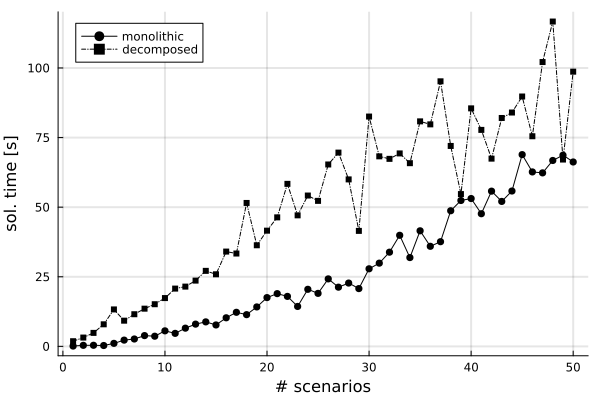

In [16]:
# solution time
p1 = plot(1:nScenMax,solTimeTraj_s[1,:],
    xlabel="# scenarios",
    ylabel="sol. time [s]",
    marker=:circle,
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p1 = plot!(1:nScenMax,solTimeTraj_s[2,:],
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p1)

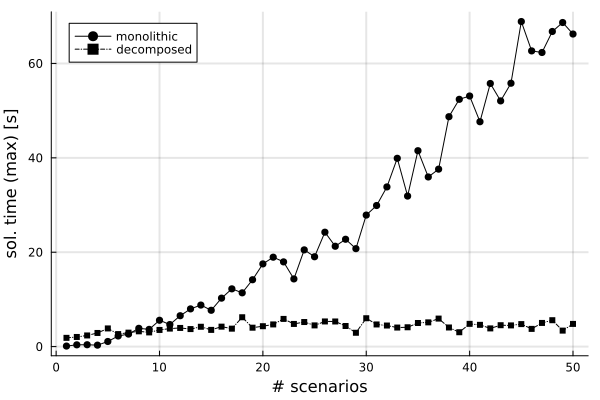

In [17]:
# solution time (parallel)
p1b = plot(1:nScenMax,solTimeTraj_s[1,:],
    xlabel="# scenarios", 
    ylabel="sol. time (max) [s]",
    marker=:circle, 
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p1b = plot!(1:nScenMax,solTimeMaxTraj_s,
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p1b)
#savefig(p1b,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C2_r5_SolTimePar.pdf");

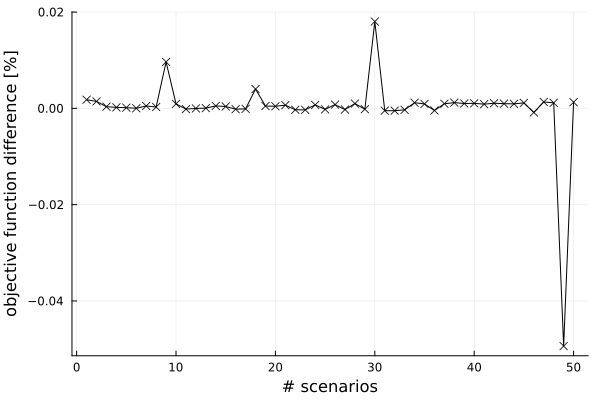

In [18]:
# objective function (parallel)
p2 = plot(1:nScenMax,100*(solObjTraj_s[2,:] - solObjTraj_s[1,:])./solObjTraj_s[1,:],
    xlabel="# scenarios", 
    ylabel="objective function difference [%]",
    marker=:xcross, 
    markercolor = :black,
    linecolor = :black,
    label="",
    dpi=600)

display(p2)

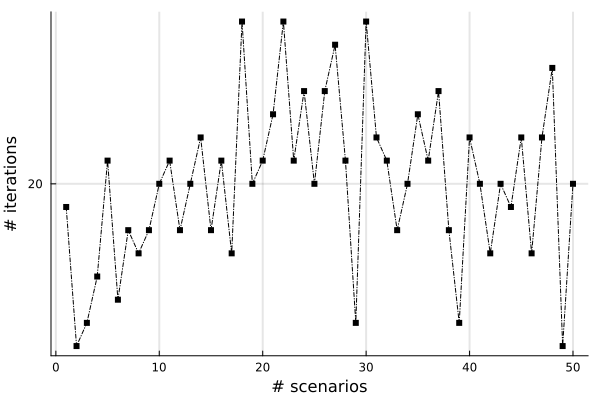

In [19]:
p3 = plot(1:nScenMax,iterTraj_s,xlabel="# scenarios", ylabel="# iterations",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    yticks=range(0,150,step=10),
    gridlinewidth=2,
    dpi=600)

display(p3)

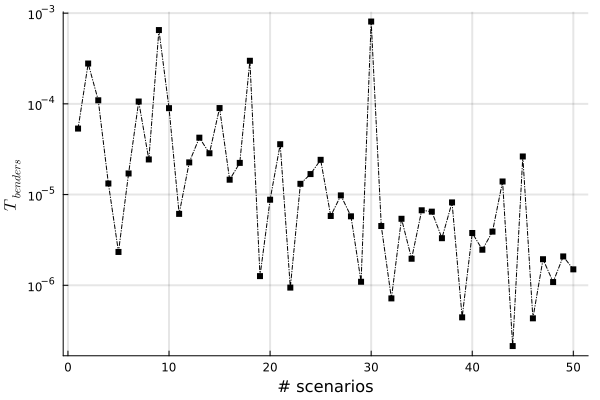

In [20]:
p4 = plot(1:nScenMax,optGapTraj_s,
    yscale=:log10,
    xlabel="# scenarios", 
    ylabel=L"T_{benders}",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    gridlinewidth=2,
    dpi=600)

display(p4)

Creating table to show the results

In [21]:
# Scenarios
table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_solMax = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30 40 50] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_s[1,tt])
    push!(table_solTime_D, solTimeTraj_s[2,tt])
    push!(table_solMax, solTimeMaxTraj_s[tt])
    push!(table_of_M, solObjTraj_s[1,tt])
    push!(table_of_D, solObjTraj_s[2,tt])
    push!(table_perChange, 100*(solObjTraj_s[2,tt] - solObjTraj_s[1,tt])/solObjTraj_s[1,tt])
end

df_scen = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 sol_time_D_max = table_solMax,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange);

In [22]:
display("Analysis: # of Scenarios")
display(df_scen)

"Analysis: # of Scenarios"

Row,iter,sol_time_M,sol_time_D,sol_time_D_max,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any,Any
1,5,1.083,13.272,3.849,0.434429,0.434429,0.000145595
2,10,5.578,17.351,3.528,0.434419,0.434423,0.000926642
3,15,7.693,25.892,3.54,0.434314,0.434315,0.00039396
4,20,17.522,41.563,4.32,0.434302,0.434304,0.000434518
5,25,19.039,52.267,4.491,0.434308,0.434307,-0.000210775
6,30,27.869,82.555,6.009,0.434293,0.434371,0.0180315
7,40,53.105,85.495,4.819,0.434292,0.434297,0.00104806
8,50,66.236,98.678,4.806,0.434281,0.434287,0.00128899
